In [49]:
import numpy as np
import pandas as pd
import json, csv
import os

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

In [154]:
## Functions for Metrics:
def print_stats_percentage_train_test(algo, y_test, y_pred):
    #Converting inputs to cpu tensors because cuda ones can't be converted to numpy:
    
    print("Algorithm: ", algo)
    
    print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    
    print("confusion matrix")
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(confmat)
    
def print_conf_matrix(y_test, y_pred, names):
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels=names)
    fig, ax = plt.subplots(figsize=(15,15))
    display.plot(ax=ax)

## Import dataset

In [155]:
DATASET_DIR = "data/"

In [156]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [157]:
nba_data = pd.read_csv(DATASET_DIR + "nba_dataset.csv", index_col=False, header=None)
nba_data

,0,1,2,3,4,5,6,7,8,9,...,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374
0,31,64,64,35.2,7.9,18.1,0.435,2.8,7.4,0.383,...,0.554,0.525,13.0,25.6,0.170,0.576,12.0,74.9,0.201,1
1,25,63,63,34.4,8.6,17.1,0.503,3.1,7.6,0.401,...,0.585,0.550,12.7,22.6,0.202,0.540,11.0,76.1,0.194,1
2,26,61,61,35.5,9.7,20.3,0.477,3.5,9.3,0.376,...,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,1
3,33,53,53,36.9,6.5,14.6,0.441,2.8,7.3,0.384,...,0.561,0.520,13.3,24.9,0.227,0.557,11.9,74.0,0.231,1
4,26,66,66,36.4,8.3,18.0,0.460,1.9,5.4,0.352,...,0.587,0.550,12.2,20.1,0.203,0.544,13.5,77.8,0.197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26617,29,73,73,32.7,6.1,12.7,0.476,1.1,3.0,0.356,...,0.537,0.501,12.5,27.1,0.198,0.496,11.7,75.1,0.195,1
26618,25,65,65,38.7,6.5,14.0,0.462,1.1,3.0,0.378,...,0.534,0.499,14.0,24.9,0.192,0.481,12.9,77.3,0.210,0
26619,36,35,35,34.5,7.6,20.4,0.373,1.5,5.3,0.293,...,0.518,0.479,12.7,26.6,0.204,0.504,13.0,74.7,0.239,1
26620,25,60,60,35.0,6.8,16.5,0.413,0.4,1.5,0.284,...,0.542,0.490,14.8,26.5,0.276,0.507,11.8,75.2,0.200,1


In [158]:
data = torch.tensor(nba_data.to_numpy())

In [159]:
data

tensor([[31.0000, 64.0000, 64.0000,  ..., 74.9000,  0.2010,  1.0000],
        [25.0000, 63.0000, 63.0000,  ..., 76.1000,  0.1940,  1.0000],
        [26.0000, 61.0000, 61.0000,  ..., 77.8000,  0.1750,  1.0000],
        ...,
        [36.0000, 35.0000, 35.0000,  ..., 74.7000,  0.2390,  1.0000],
        [25.0000, 60.0000, 60.0000,  ..., 75.2000,  0.2000,  1.0000],
        [30.0000, 44.0000, 44.0000,  ..., 75.1000,  0.1950,  0.0000]],
       dtype=torch.float64)

## Organize data into dataloader

In [160]:
# Create data tensor
x_ds = data[:,:-1]
#x_ds = F.normalize(x_ds)
x_ds

tensor([[31.0000, 64.0000, 64.0000,  ..., 12.0000, 74.9000,  0.2010],
        [25.0000, 63.0000, 63.0000,  ..., 11.0000, 76.1000,  0.1940],
        [26.0000, 61.0000, 61.0000,  ..., 10.4000, 77.8000,  0.1750],
        ...,
        [36.0000, 35.0000, 35.0000,  ..., 13.0000, 74.7000,  0.2390],
        [25.0000, 60.0000, 60.0000,  ..., 11.8000, 75.2000,  0.2000],
        [30.0000, 44.0000, 44.0000,  ..., 11.7000, 75.1000,  0.1950]],
       dtype=torch.float64)

In [161]:
# Create labels tensor
y_ds = data[:,-1]
y_ds = y_ds.unsqueeze(1)

In [162]:
print(x_ds.size())
print(y_ds.size())

torch.Size([26622, 1374])
torch.Size([26622, 1])


In [163]:
# To Tensor
x_ds = x_ds.to("cuda")
y_ds = y_ds.to("cuda")

In [164]:
nba_dataset = TensorDataset( x_ds.float(), y_ds.float() )

In [165]:
n_samples = x_ds.shape[0]
n_test    = int(0.2 * n_samples)

train_ds, test_ds = random_split(nba_dataset,
                                 [n_samples - n_test,
                                  n_test
                                 ])


test_x_ds = test_ds[:][0]
test_y_ds = test_ds[:][1]

## Normalization

In [32]:
train_x_norm = F.normalize(train_ds[:][0])
train_y      = train_ds[:][1]
train_ds = TensorDataset( train_x_norm, train_y )

In [33]:
test_x_norm = F.normalize(test_ds[:][0])
test_y      = test_ds[:][1]
test_ds = TensorDataset( test_x_norm, test_y )

## Final Loaders

In [166]:
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader  = DataLoader( test_ds, batch_size, shuffle=False)

## Model
#### TODO: LSTM

In [142]:
# 3D Vector: ( Games? * Number of Players * Features)??
class LSMTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(3600, 1800, batch_first=True)
        self.fc1 = nn.Linear(1800, 1)
        
    def forward(self, x):
        x_, (h_n, c_n) = self.lstm(x)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return x_

## Model
#### TODO: GAN

In [ ]:
from utils import Logger

from torch.autograd.variable import Variable

In [ ]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 1350
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 1350
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [ ]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 1350))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), 1350)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [ ]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [ ]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='NBA_Games')
# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(train_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

## Model Init

In [167]:
# Same as linear regression! 
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()

        self.input   = nn.Linear(input_dim, 675)
        self.hidden  = nn.Linear(675, 675)
        self.output  = nn.Linear(675, output_dim)

        self.dropout = nn.Dropout(0.2)
        self.bnorm   = nn.BatchNorm1d(675)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.dropout( x )
        x = self.bnorm( x )
        x = self.relu( x )

        x = self.hidden(x)
        x = self.relu( x )

        x = self.hidden(x)
        x = self.relu( x )

        x = self.hidden(x)
        x = self.dropout( x )
        x = self.bnorm( x )
        x = self.relu( x )
        
        x = self.output( x )
        x = self.sigmoid( x )

        return x

In [168]:
# Hyperparameters
learning_rate = 1e-3
n_epochs = 400

In [169]:
# failed = 1
#while(failed):

model   = LogisticRegressionModel(1374, 1).to('cuda')
loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

model.train()
with tqdm( range(n_epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        for input, labels in train_loader:                  ## input[64x1xWxH] (64 or 256)
            batch_size    = input.shape[0]
            input_resized = input.view(batch_size,-1) ## converts stats to [64x1350] which is what the network expects

            outputs  = model(input_resized)
            loss     = loss_fn(outputs, labels)
            correct  = (outputs>0 == labels).sum().item()
            accuracy = correct / batch_size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # scheduler.step()
        tepoch.set_postfix(loss=loss.item(), accuracy=f'{100. * accuracy}%')
        # tepoch.set_postfix(epoch=epoch, loss=loss.item(), accuracy=f'{100. * accuracy}%', cur_lr=scheduler.get_last_lr())
        
    model.eval()

100%|██████████| 400/400 [06:55<00:00,  1.04s/epoch, accuracy=14.000000000000002%, loss=0.0263]


NBA Dataset Training with 3H-DL Model:
Algorithm:  3HDL
Accuracy: 0.66
Precision: 0.652
Recall: 0.659
F1-measure: 0.651
confusion matrix
[[1037 1120]
 [ 696 2471]]
              precision    recall  f1-score   support

   away_team       0.60      0.48      0.53      2157
   home_team       0.69      0.78      0.73      3167

    accuracy                           0.66      5324
   macro avg       0.64      0.63      0.63      5324
weighted avg       0.65      0.66      0.65      5324



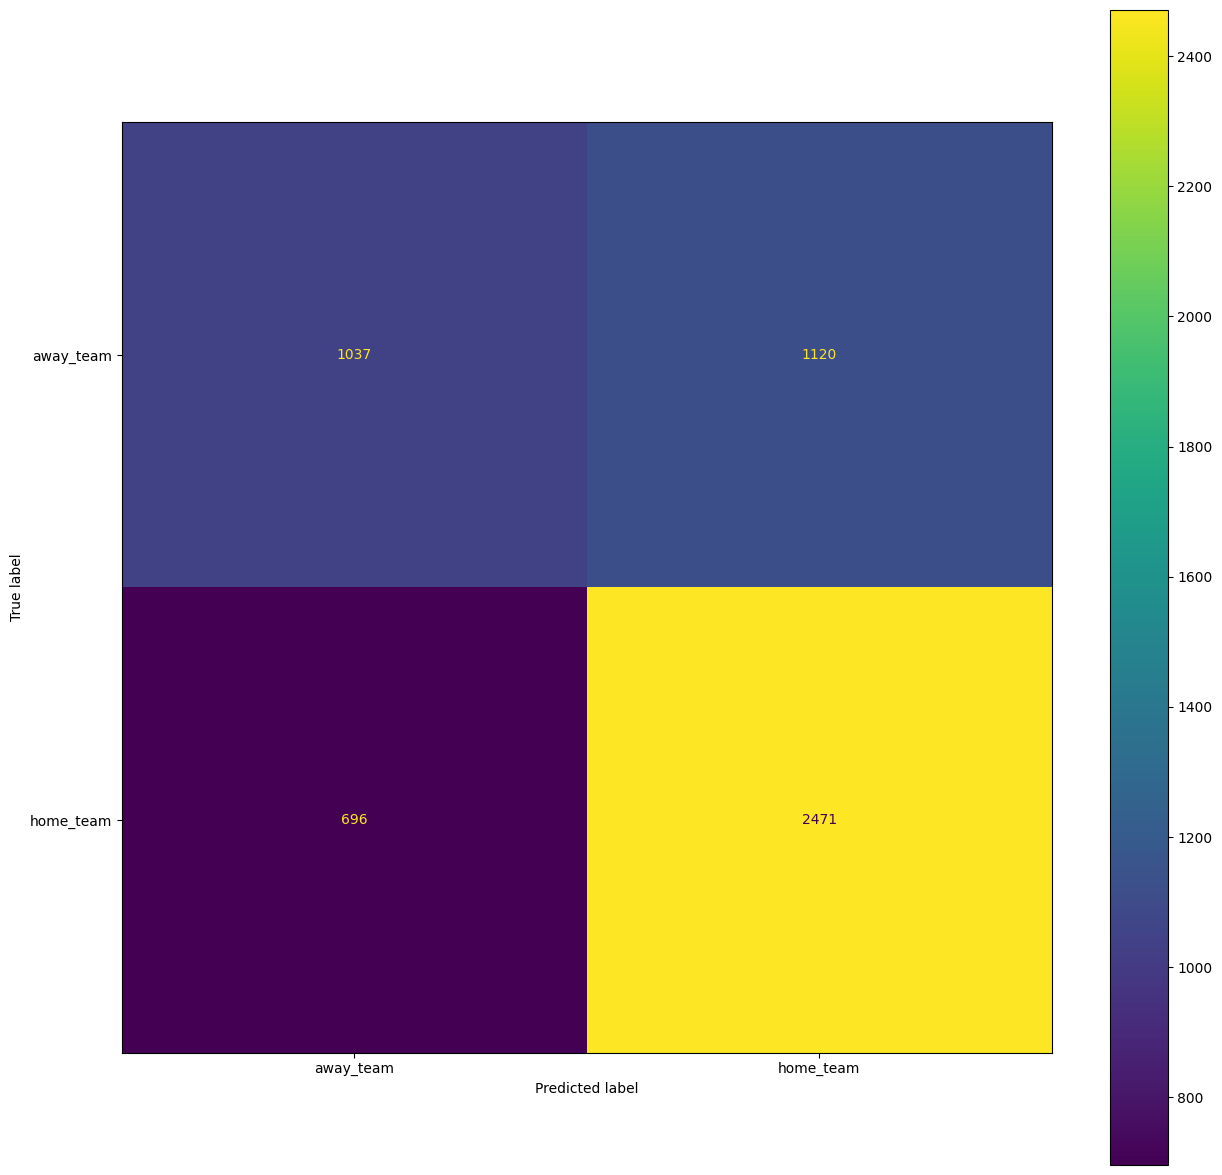

In [172]:
print("NBA Dataset Training with 3H-DL Model:")

l_pred = []
names = ["away_team", "home_team"]

with torch.no_grad():
    for imgs, img_labels in test_loader:
        batch_size  = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)
        
        outputs     = model(imgs_resized)
        
        pred        = (outputs>0.50).float()
        
        l_pred.append(pred)
    
    l_pred = torch.cat(l_pred)
    
    print_stats_percentage_train_test("3HDL", test_y_ds.cpu(), l_pred.cpu())
    
    print(classification_report(test_y_ds.cpu(), l_pred.cpu(), target_names=names))

    print_conf_matrix(test_y_ds.cpu(),
                    l_pred.cpu(),
                    names)

## Saving Model

In [171]:
torch.save(model.state_dict(), "model.pth")

## Load Model

In [33]:
model = LogisticRegressionModel(1374, 1).to('cuda')
model.load_state_dict(torch.load("model.pth"))
# model.eval()

<All keys matched successfully>

In [ ]:
# torch.save(model, "model.pth")
# model = torch.load("model.pth")

## Testing: on 'test_game.csv' Dataset

In [278]:
test_data = pd.read_csv(DATASET_DIR + "test_game.csv", index_col=False, header=None)
test_data

,0,1,2,3,4,5,6,7,8,9,...,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374
0,27,64,64,33.9,9.5,15.0,0.634,0.8,2.1,0.394,...,0.582,0.542,12.3,22.8,0.232,0.535,10.9,76.3,0.171,0
1,27,64,64,33.9,9.5,15.0,0.634,0.8,2.1,0.394,...,0.582,0.542,12.3,22.8,0.232,0.535,10.9,76.3,0.171,0
2,38,47,47,36.1,11.3,22.6,0.501,2.1,6.9,0.308,...,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,0
3,38,47,47,36.1,11.3,22.6,0.501,2.1,6.9,0.308,...,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,0
4,27,64,64,33.9,9.5,15.0,0.634,0.8,2.1,0.394,...,0.582,0.542,12.3,22.8,0.232,0.535,10.9,76.3,0.171,0
5,38,47,47,36.1,11.3,22.6,0.501,2.1,6.9,0.308,...,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,0
6,27,64,64,33.9,9.5,15.0,0.634,0.8,2.1,0.394,...,0.582,0.542,12.3,22.8,0.232,0.535,10.9,76.3,0.171,0


In [279]:
test_data = torch.tensor(test_data.to_numpy())
test_data

tensor([[27.0000, 64.0000, 64.0000,  ..., 76.3000,  0.1710,  0.0000],
        [27.0000, 64.0000, 64.0000,  ..., 76.3000,  0.1710,  0.0000],
        [38.0000, 47.0000, 47.0000,  ..., 76.4000,  0.2010,  0.0000],
        ...,
        [27.0000, 64.0000, 64.0000,  ..., 76.3000,  0.1710,  0.0000],
        [38.0000, 47.0000, 47.0000,  ..., 76.4000,  0.2010,  0.0000],
        [27.0000, 64.0000, 64.0000,  ..., 76.3000,  0.1710,  0.0000]],
       dtype=torch.float64)

In [280]:
test_data = test_data.float().to("cuda")[:,:-1]
# test_data = test_data.unsqueeze(0)


In [281]:
test_data

tensor([[27.0000, 64.0000, 64.0000,  ..., 10.9000, 76.3000,  0.1710],
        [27.0000, 64.0000, 64.0000,  ..., 10.9000, 76.3000,  0.1710],
        [38.0000, 47.0000, 47.0000,  ..., 12.2000, 76.4000,  0.2010],
        ...,
        [27.0000, 64.0000, 64.0000,  ..., 10.9000, 76.3000,  0.1710],
        [38.0000, 47.0000, 47.0000,  ..., 12.2000, 76.4000,  0.2010],
        [27.0000, 64.0000, 64.0000,  ..., 10.9000, 76.3000,  0.1710]],
       device='cuda:0')

In [282]:
outputs = model(test_data)

In [283]:
outputs

tensor([[0.9974],
        [0.9974],
        [0.1702],
        [0.1702],
        [0.9974],
        [0.1702],
        [0.9974]], device='cuda:0', grad_fn=<SigmoidBackward0>)